In [29]:
basedir = '/home/jun/sortrun/'

In [30]:
import os
import re
import string
from typing import Dict, List, Tuple
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.lines import Line2D


def find_top5_asymmetry(data: np.ndarray) -> Tuple:
    asymmetry_matrix = np.abs(np.triu(data, k=1) - np.tril(data, k=-1).T)
    asymmetry_combinations = np.triu(asymmetry_matrix, k=1)
    top5_indices = np.unravel_index(np.argsort(
        asymmetry_combinations, axis=None)[-5:], asymmetry_combinations.shape)
    return top5_indices


def draw_heatmap(title: str, data: np.ndarray, eventList: list) -> None:
    xticklabels = eventList
    yticklabels = list(reversed(eventList))
    matrix_flipped = np.flipud(data)
    ax = sns.heatmap(matrix_flipped, xticklabels=xticklabels,
                     yticklabels=yticklabels)
    plt.gcf().set_size_inches(10, 8)
    line = Line2D([matrix_flipped.shape[1], 0], [
        0, matrix_flipped.shape[0]], color='red')
    plt.gca().add_line(line)
    plt.title(title)
    plt.show()


def draw_heatmap_group(comment: str, m16: np.ndarray, m32: np.ndarray, m64: np.ndarray, m256: np.ndarray, eventList: list) -> None:
    xticklabels = eventList
    yticklabels = list(reversed(eventList))
    matrix_flipped1 = np.flipud(m16)
    matrix_flipped2 = np.flipud(m32)
    matrix_flipped3 = np.flipud(m64)
    matrix_flipped4 = np.flipud(m256)

    fig, axs = plt.subplots(2, 2)

    sns.heatmap(matrix_flipped1, ax=axs[0, 0], xticklabels=xticklabels,
                yticklabels=yticklabels)
    sns.heatmap(matrix_flipped2, ax=axs[0, 1], xticklabels=xticklabels,
                yticklabels=yticklabels)
    sns.heatmap(matrix_flipped3, ax=axs[1, 0], xticklabels=xticklabels,
                yticklabels=yticklabels)
    sns.heatmap(matrix_flipped4, ax=axs[1, 1], xticklabels=xticklabels,
                yticklabels=yticklabels)

    fig.autofmt_xdate(rotation=45)

    axs[0, 0].set_title('Time Window: 16 cycle')
    axs[0, 1].set_title('Time Window: 32 cycle')
    axs[1, 0].set_title('Time Window: 64 cycle')
    axs[1, 1].set_title('Time Window: 256 cycle')

    fig.suptitle(comment, x=0.45, y=0.95, fontsize=16)
    plt.gcf().set_size_inches(17, 15.5)
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    for ax in axs.flatten():
        line = Line2D([matrix_flipped1.shape[1], 0], [
                      0, matrix_flipped1.shape[0]], color='white')
        ax.add_line(line)
        # ax.xaxis.labelpad = 1.0
        # ax.tick_params(axis='x', pad=0)

    import matplotlib.transforms as mtransforms
    for ax in axs.flatten():
        labels = ax.get_xticklabels()
        for label in labels:
            trans = mtransforms.Affine2D().translate(0.5, 23.3) + ax.transData
            label.set_transform(trans)

    plt.show()


def do_normalization(bench: str, matrix: np.ndarray, eventList: list) -> np.ndarray:
    path = os.path.join(basedir, bench)
    os.chdir(path)
    numbers = []
    final_counters = parse_stdout(bench)
    ins = int(final_counters["Executed instructions"])
    numbers = [int(final_counters[event])*1000/ins for event in eventList]

    ret = matrix / np.array(numbers)

    # error checking
    indices = np.where(ret > 1.1)
    if indices[0].size != 0:
        zipped = zip(indices[0], indices[1])
        for i, j in zipped:
            print(i, j)
            print(numbers[j]*ins/1000)
            print(eventList[i], eventList[j])
            print(ret[i][j])
        raise (Exception("Found elements at indices:", indices, bench))
    return ret


def parse_stdout(bench: str) -> Dict:
    path = os.path.join(basedir, bench)
    os.chdir(path)
    with open(bench+'.out', 'r') as f:
        text = f.read()
        lines = text.strip().split("\n")
        start_index = lines.index("1145141919810") + 1
        relevant_lines = lines[start_index:]
        key_value_pairs = [re.split(r":\s+", line) for line in relevant_lines]
        final_counters = {key: value for key, value in key_value_pairs}
    return final_counters


def get_ipc(bench: str) -> string:
    # find the line start with "IPC", capture the number after it
    path = os.path.join(basedir, bench)
    os.chdir(path)
    with open(bench+'.out', 'r') as f:
        text = f.read()
        lines = text.strip().split("\n")
        for line in lines:
            if line.startswith("IPC"):
                return line


def get_miss(bench: str) -> string:
    final_count = parse_stdout(bench)
    ki = int(final_count["Executed instructions"])/1000
    ret = "MPKI of L1d: {:.4f}, L1i: {:.4f}, L2: {:.4f}, L3: {:.4f}".format(int(final_count["l1dcache.overallMisses"])/ki, int(
        final_count["l1icache.overallMisses"])/ki, int(final_count["l2cache.overallMisses"])/ki, int(final_count["l3cache.overallMisses"])/ki)

    return ret


def get_branch_miss(bench: str) -> string:
    path = os.path.join(basedir, bench, "m5out")
    os.chdir(path)
    with open('stats.txt', 'r') as f:
        text = f.read()
        lines = text.strip().split("\n")
        predicted = int()
        incorrect = int()
        for line in lines:
            if line.startswith("board.processor.cores.core.branchPred.condPredicted"):
                predicted = int(line.split()[1])
            if line.startswith("board.processor.cores.core.branchPred.condIncorrect"):
                incorrect = int(line.split()[1])
        return "branch: {:.4f}".format(incorrect/predicted)


def analyze(bench: str, normalize: bool = False) -> Tuple:
    # map = {}
    top_pairs = []

    path = os.path.join(basedir, bench)
    os.chdir(path)

    final_counters = parse_stdout(bench)

    ki = int(final_counters["Executed instructions"])/1000
    eventList = final_counters["recorded events"].split()

    assert len(eventList) == int(
        final_counters["all events count"]), "event count mismatch"

    fd = 'bc16v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m16v1 = np.array(data_list, np.uint64) / ki

    fd = 'bc16v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m16v2 = np.array(data_list, np.uint64) / ki

    fd = 'bc32v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m32v1 = np.array(data_list, np.uint64) / ki

    fd = 'bc32v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m32v2 = np.array(data_list, np.uint64) / ki

    fd = 'bc64v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m64v1 = np.array(data_list, np.uint64) / ki

    fd = 'bc64v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m64v2 = np.array(data_list, np.uint64) / ki

    fd = 'bc128v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m128v1 = np.array(data_list, np.uint64) / ki

    fd = 'bc128v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m128v2 = np.array(data_list, np.uint64) / ki

    fd = 'bc256v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m256v1 = np.array(data_list, np.uint64) / ki

    fd = 'bc256v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m256v2 = np.array(data_list, np.uint64) / ki

    m32v1 = m32v1 + m16v1
    m32v2 = m32v2 + m16v2
    m64v1 = m64v1 + m32v1
    m64v2 = m64v2 + m32v2
    m128v1 = m128v1 + m64v1
    m128v2 = m128v2 + m64v2
    m256v1 = m256v1 + m128v1
    m256v2 = m256v2 + m128v2

    if normalize == True:
        for i, m in enumerate([m16v1, m16v2, m32v1, m32v2, m64v1, m64v2, m128v1, m128v2, m256v1, m256v2]):
            # print(i)
            m = do_normalization(bench, m, eventList)
            if i == 0:
                m16v1 = m
            elif i == 1:
                m16v2 = m
            elif i == 2:
                m32v1 = m
            elif i == 3:
                m32v2 = m
            elif i == 4:
                m64v1 = m
            elif i == 5:
                m64v2 = m
            elif i == 6:
                m128v1 = m
            elif i == 7:
                m128v2 = m
            elif i == 8:
                m256v1 = m
            elif i == 9:
                m256v2 = m

    top5_asymmetry_results = {}
    top5_asymmetry_results[bench] = find_top5_asymmetry(m256v2)
    # indices in index of event
    indices = top5_asymmetry_results[bench]
    top_pairs = [(eventList[i], eventList[j]) for i, j in zip(*indices)]

    max_index = np.unravel_index(np.argmax(m16v2, axis=None), m16v2.shape)
    top16 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m32v2, axis=None), m32v2.shape)
    top32 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m64v2, axis=None), m64v2.shape)
    top64 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m128v2, axis=None), m128v2.shape)
    top128 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m256v2, axis=None), m256v2.shape)
    top256 = (eventList[max_index[0]], eventList[max_index[1]])

    tops = zip("top16, top32, top64, top128, top256".split(", "),
               [top16, top32, top64, top128, top256])

    # m = {key: value for (key, value) in zip("m16v1, m32v1, m64v1, m128v1, m256v1".split(
    #     ", "), [m16v1, m32v1, m64v1, m128v1, m256v1])}

    m = {key: value for (key, value) in zip("m16v2, m32v2, m64v2, m128v2, m256v2".split(
        ", "), [m16v2, m32v2, m64v2, m128v2, m256v2])}

    # for i in "m16v2, m32v2, m64v2, m128v2, m256v2".split(', '):
    #     print(m[i])

    # return matrixs[bench], top_pairs[bench], tops[bench], events[bench]
    return m, top_pairs, dict(tops), eventList

In [31]:
benchlist = '''stlintrosort stlstablesort stlheapsort
 combsort libcqsort itermergesort paulheapsort paulquicksort paulmergesort'''.split()

comment = {

}

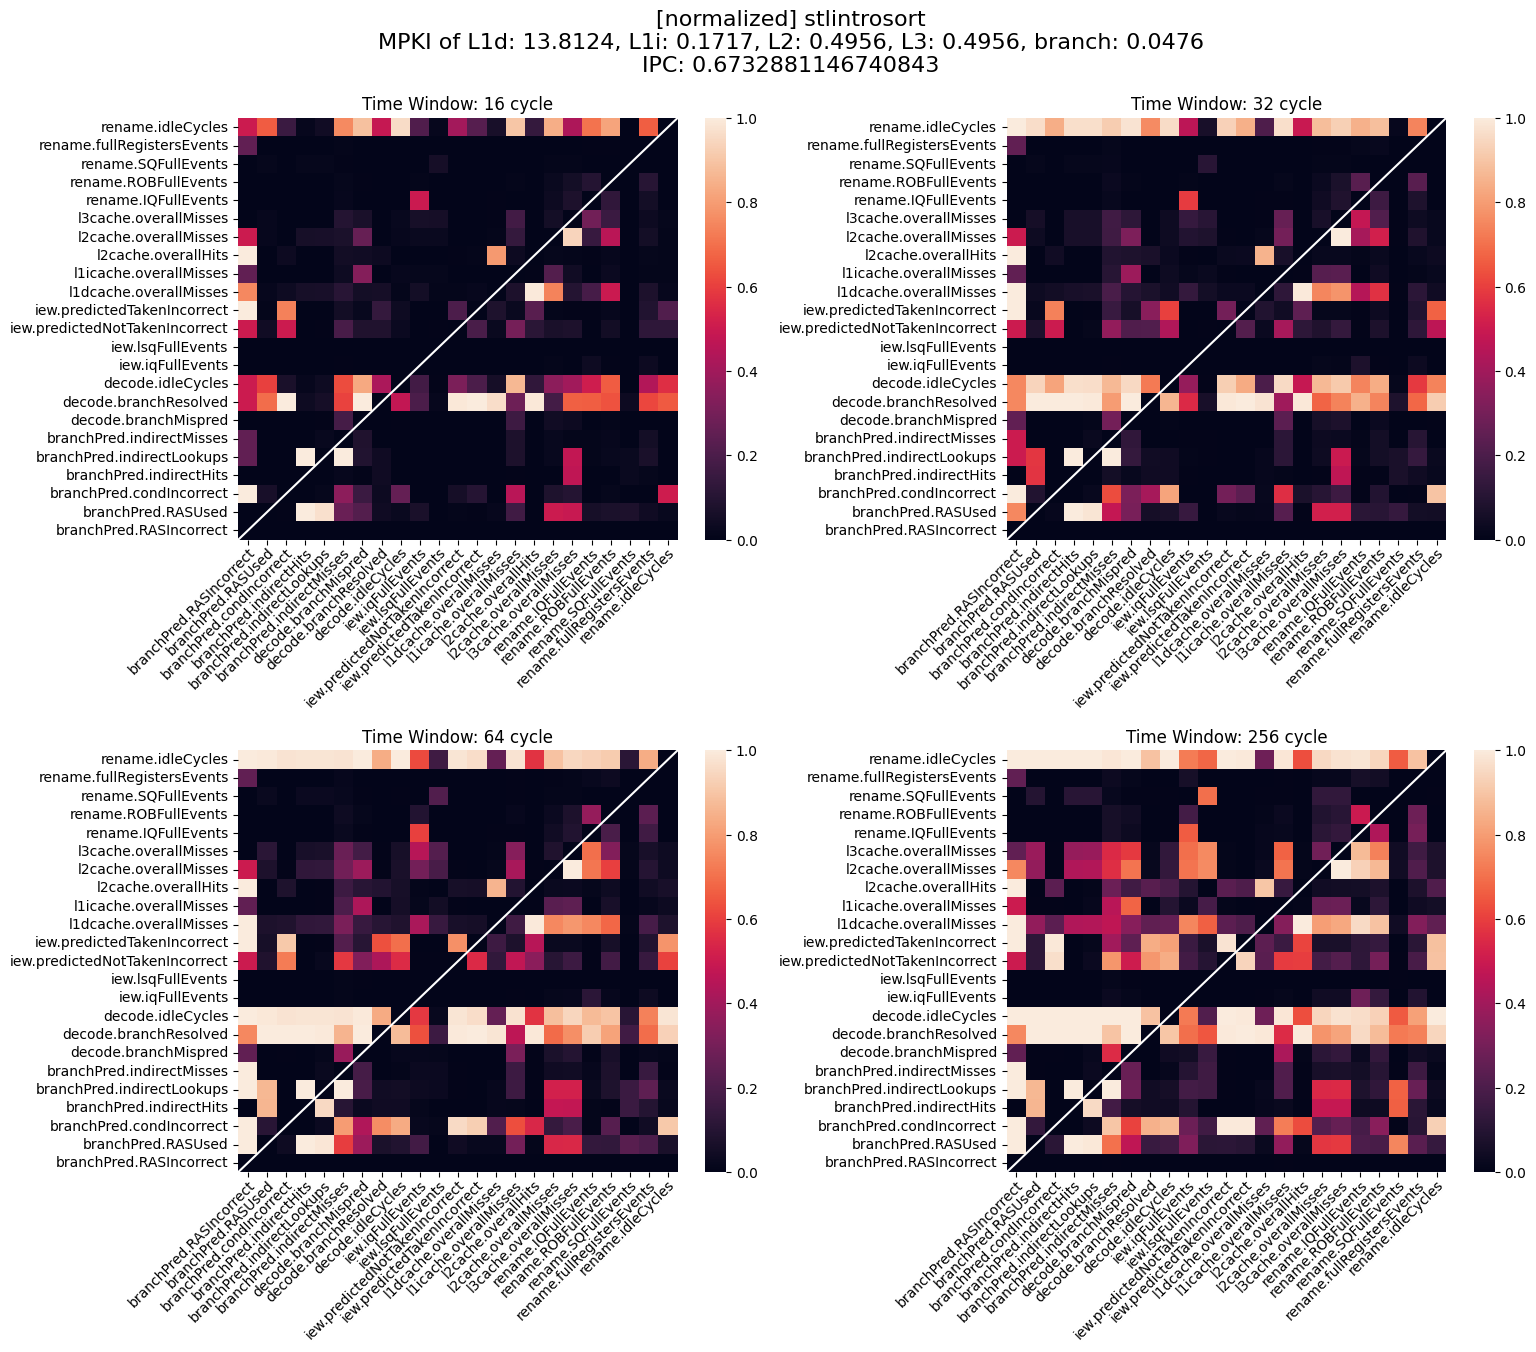

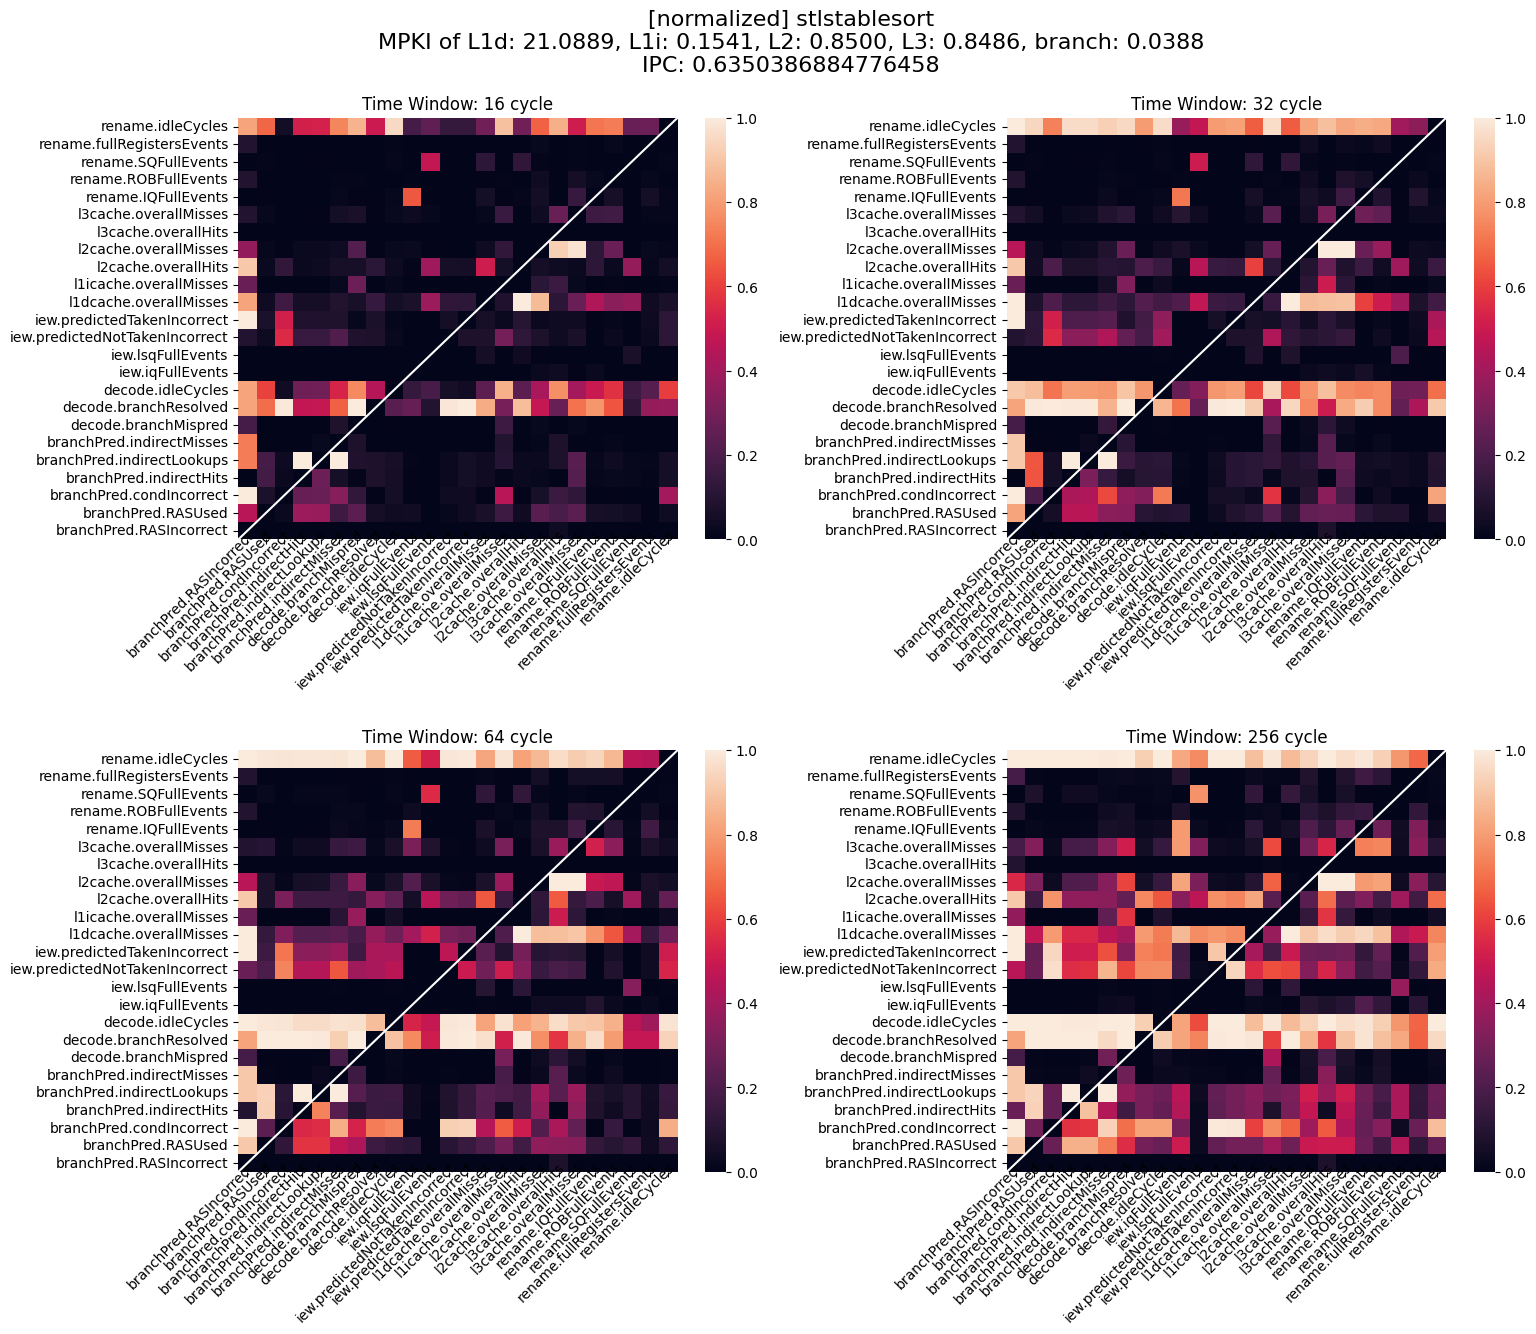

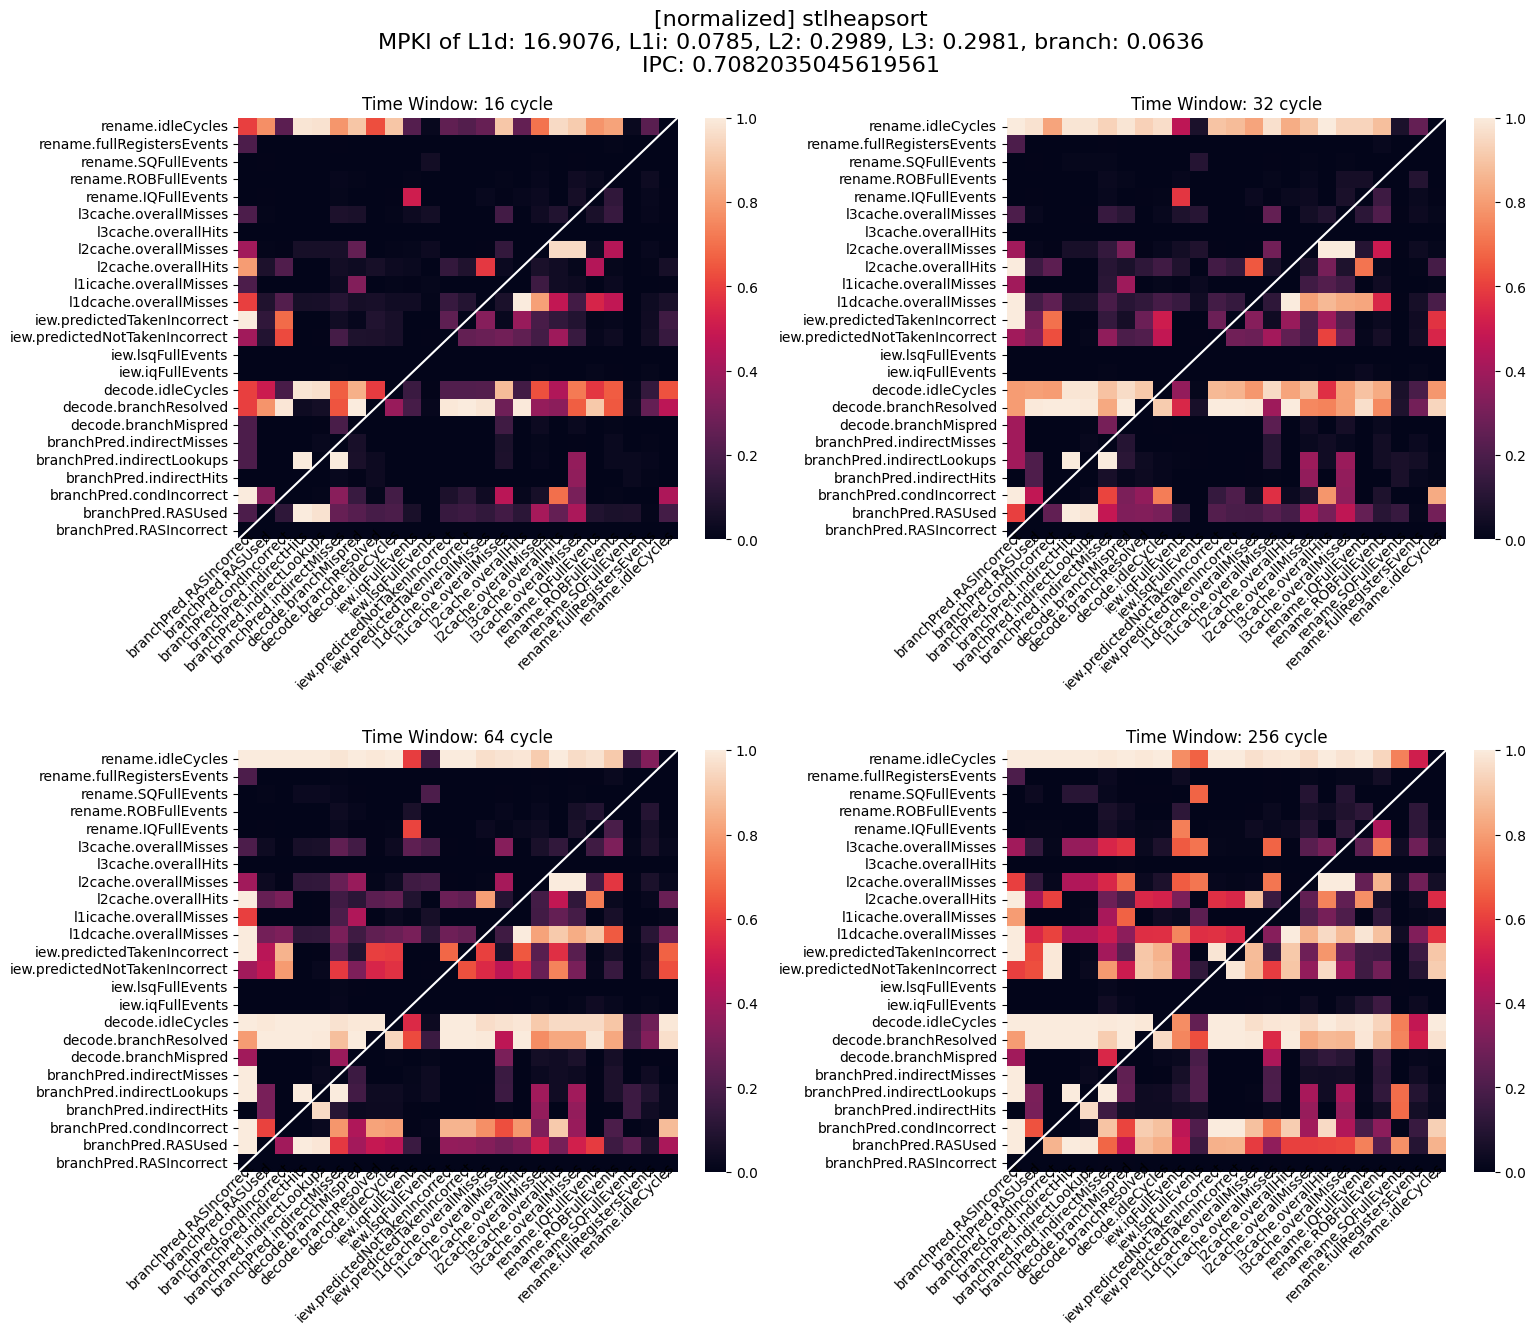

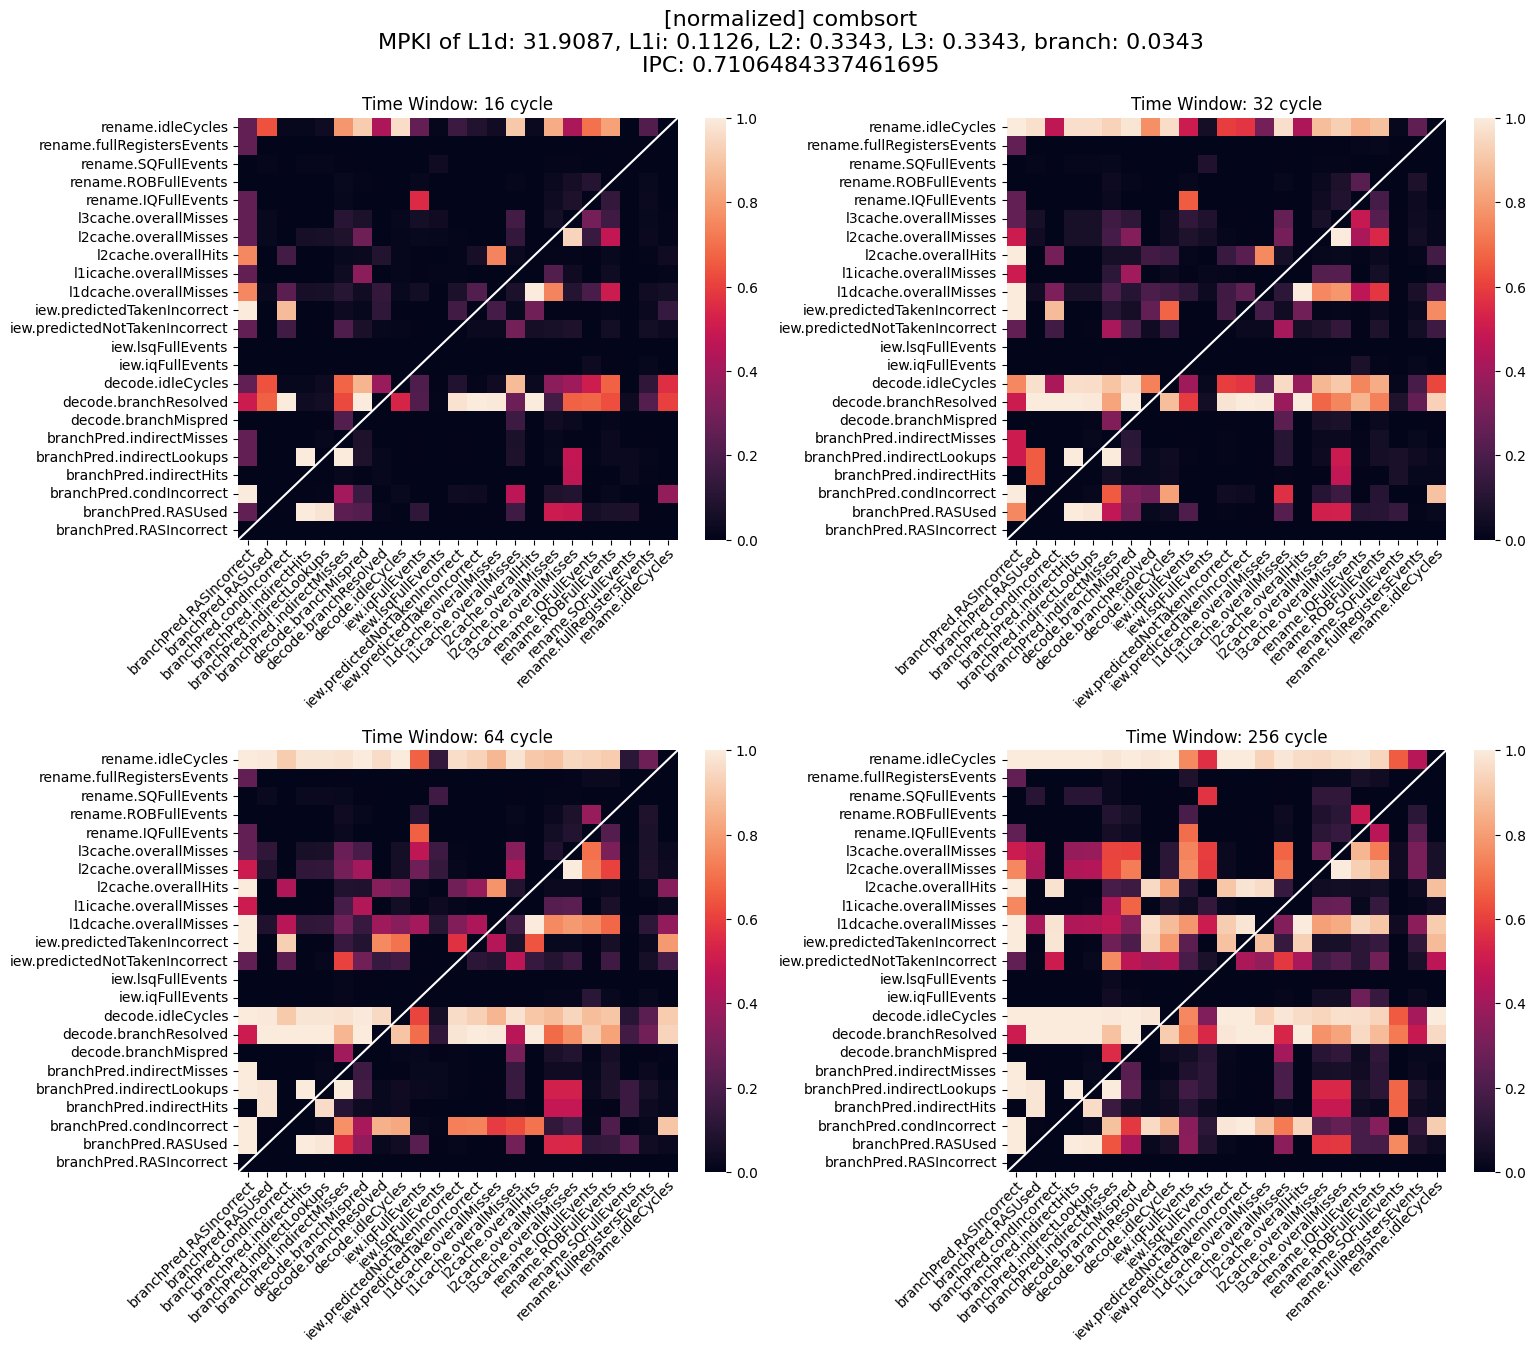

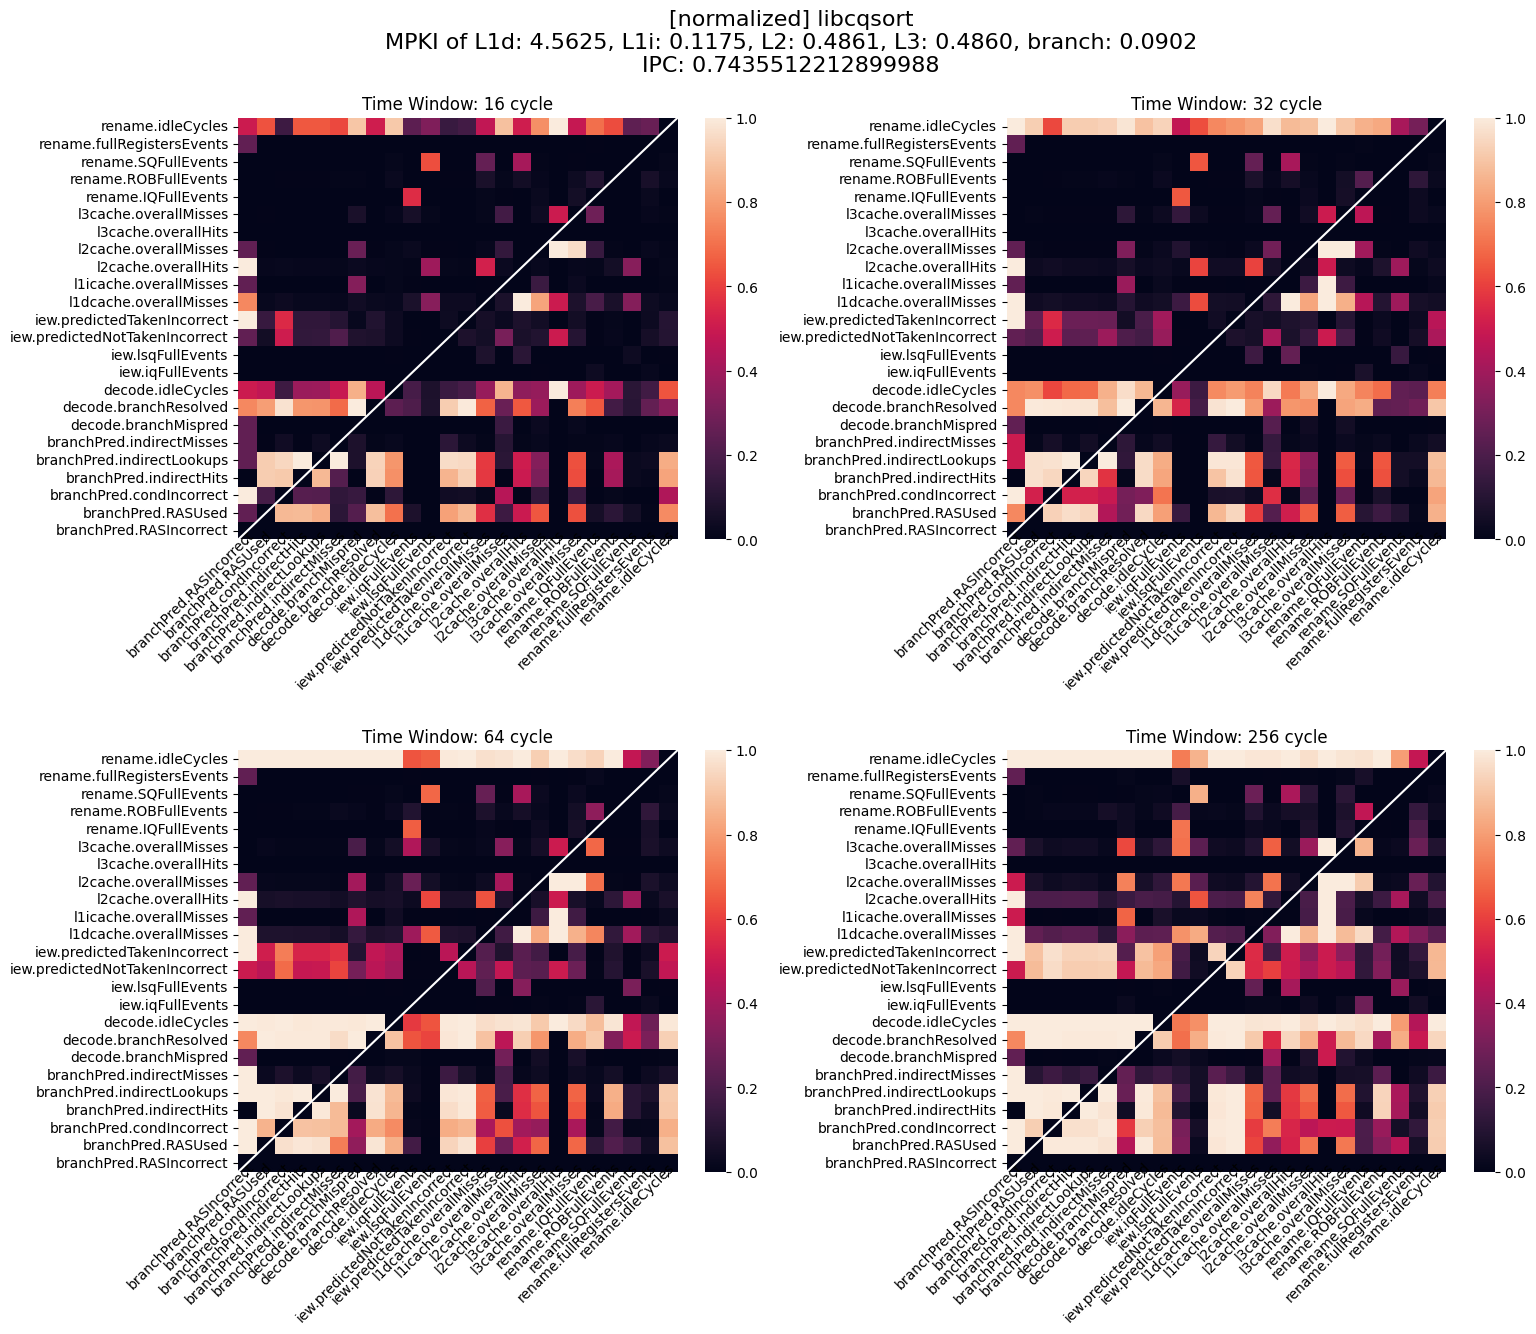

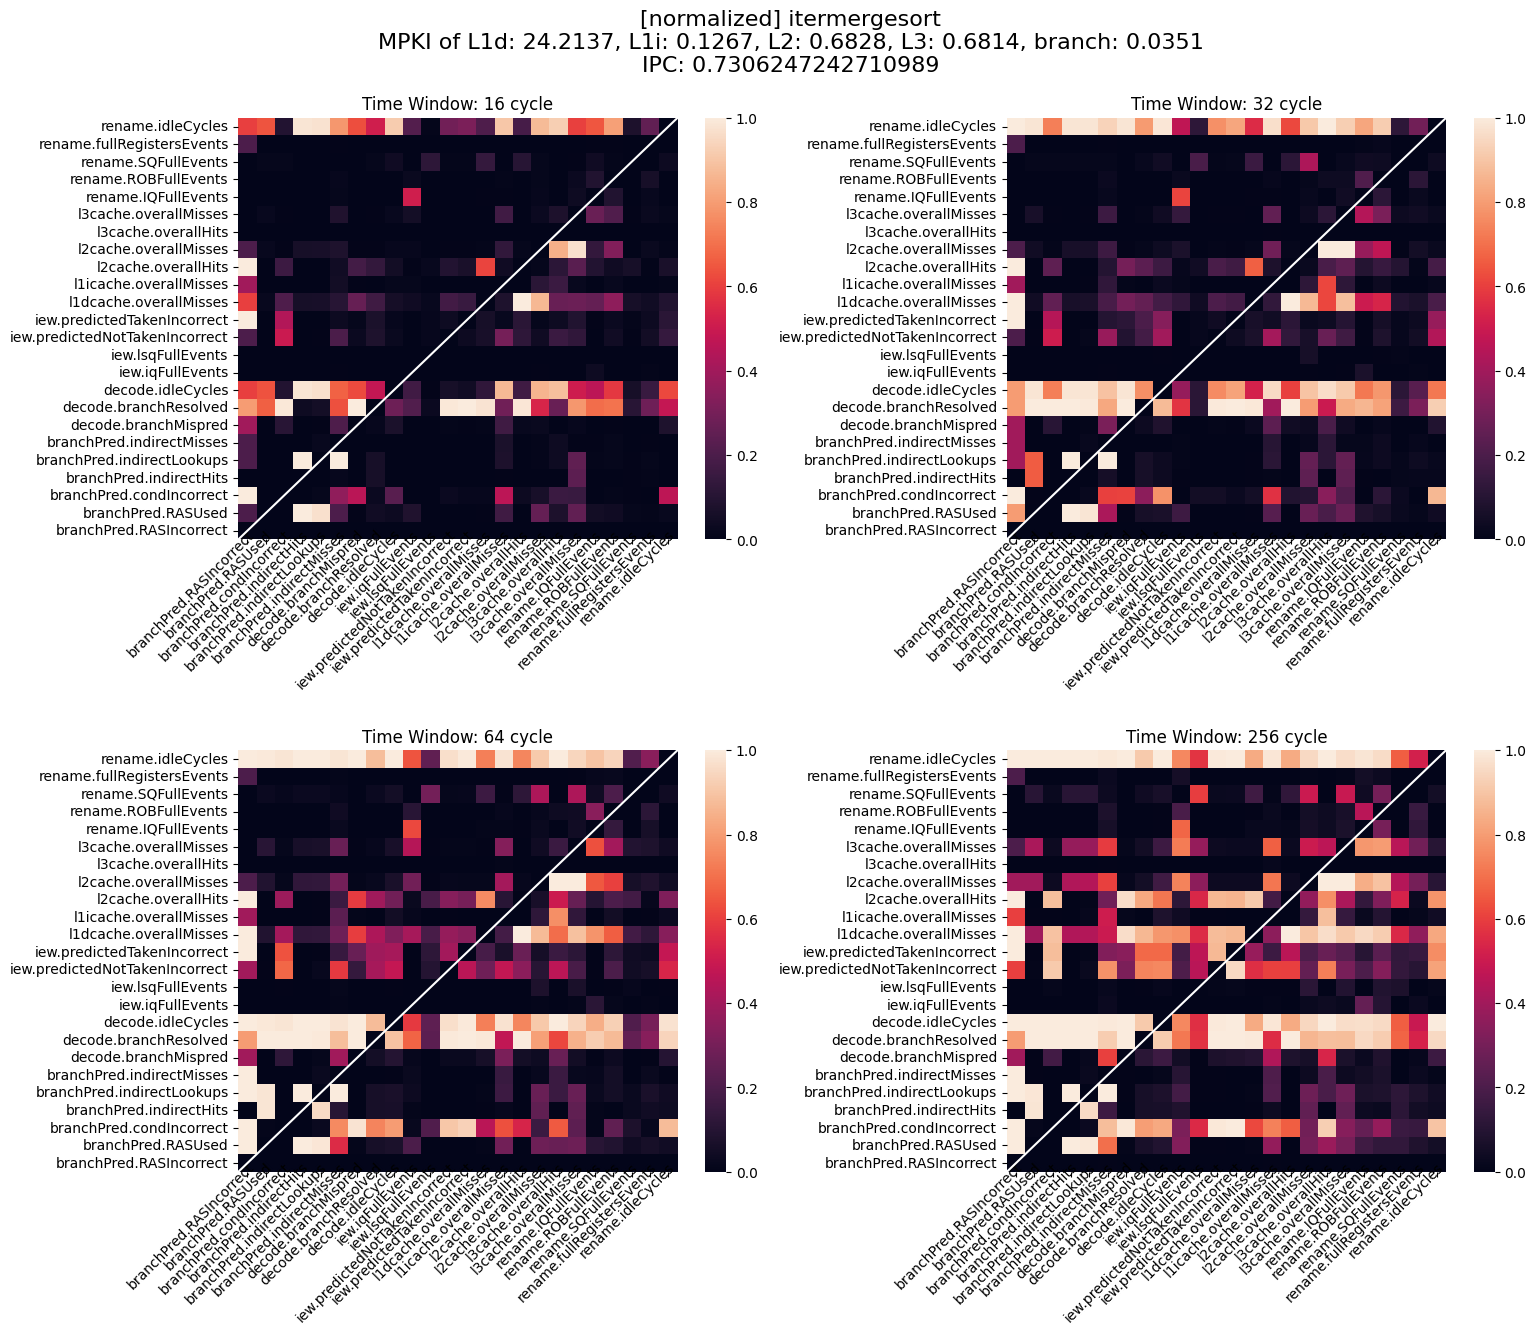

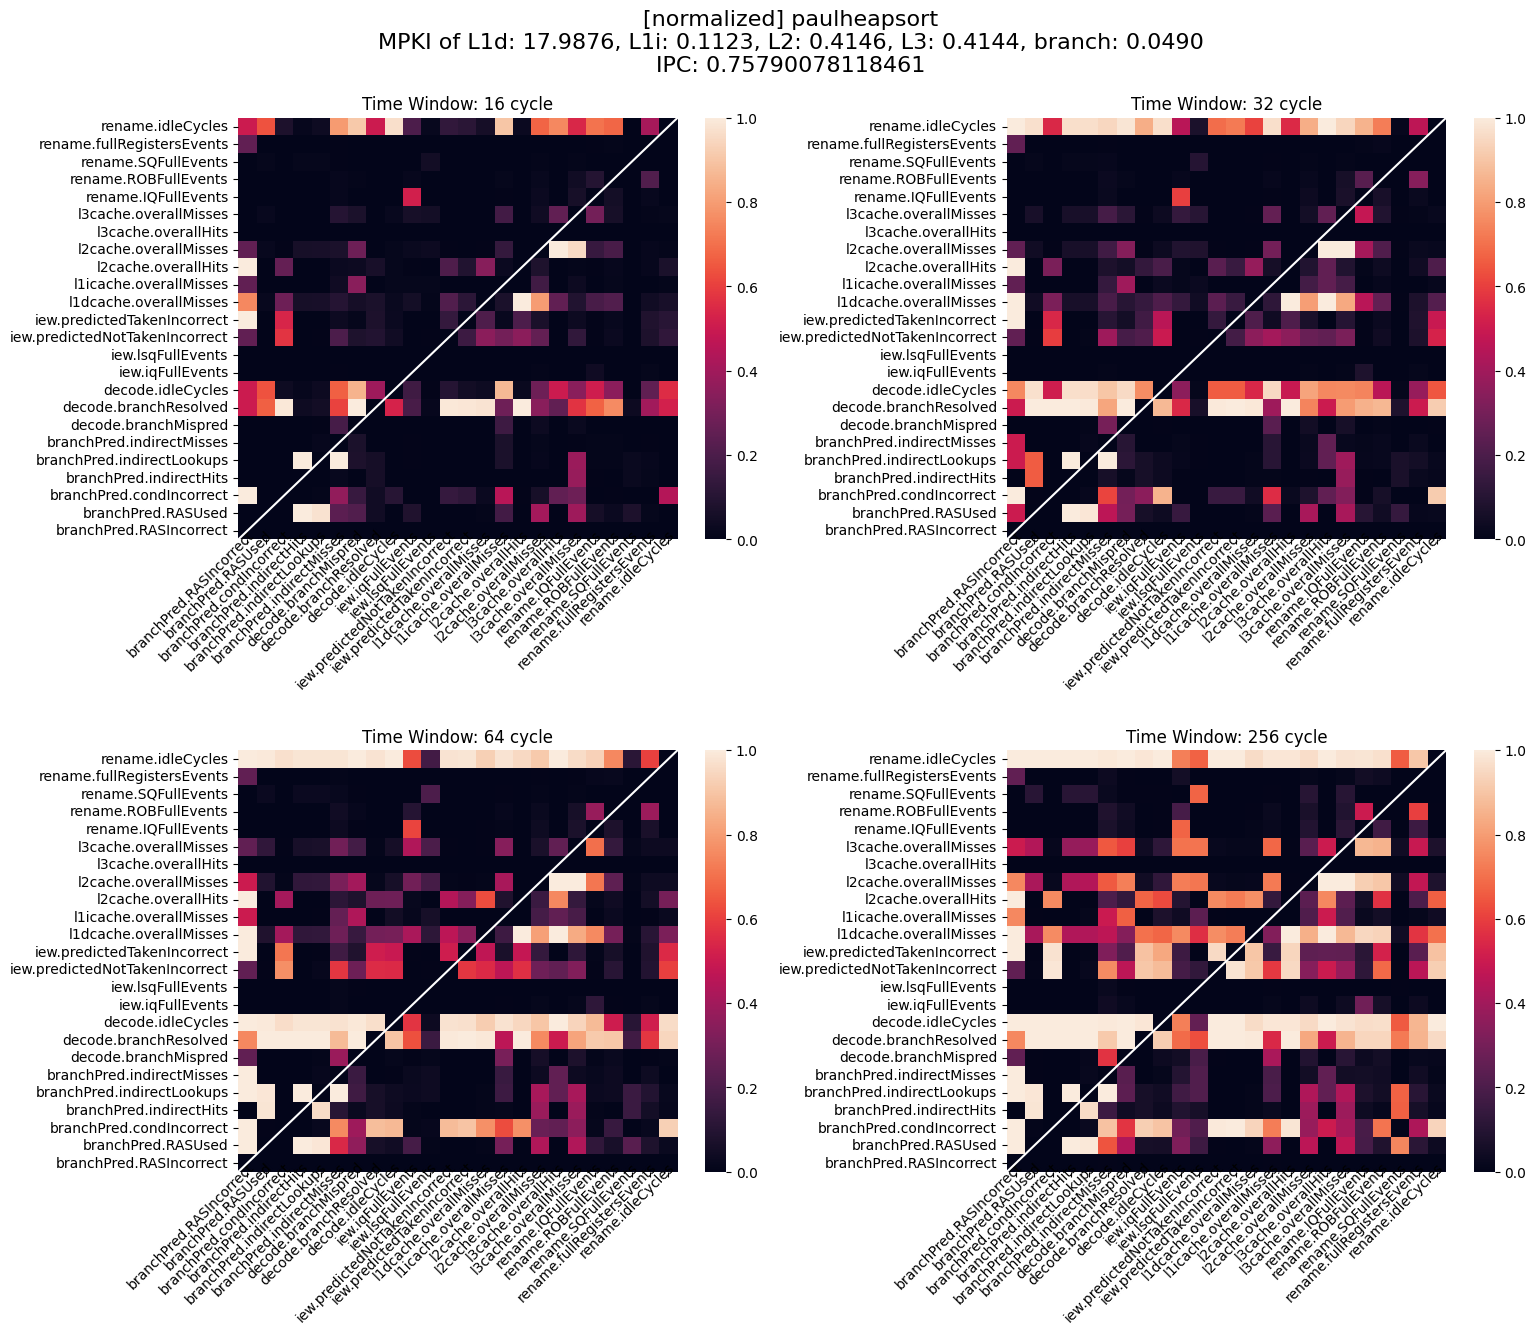

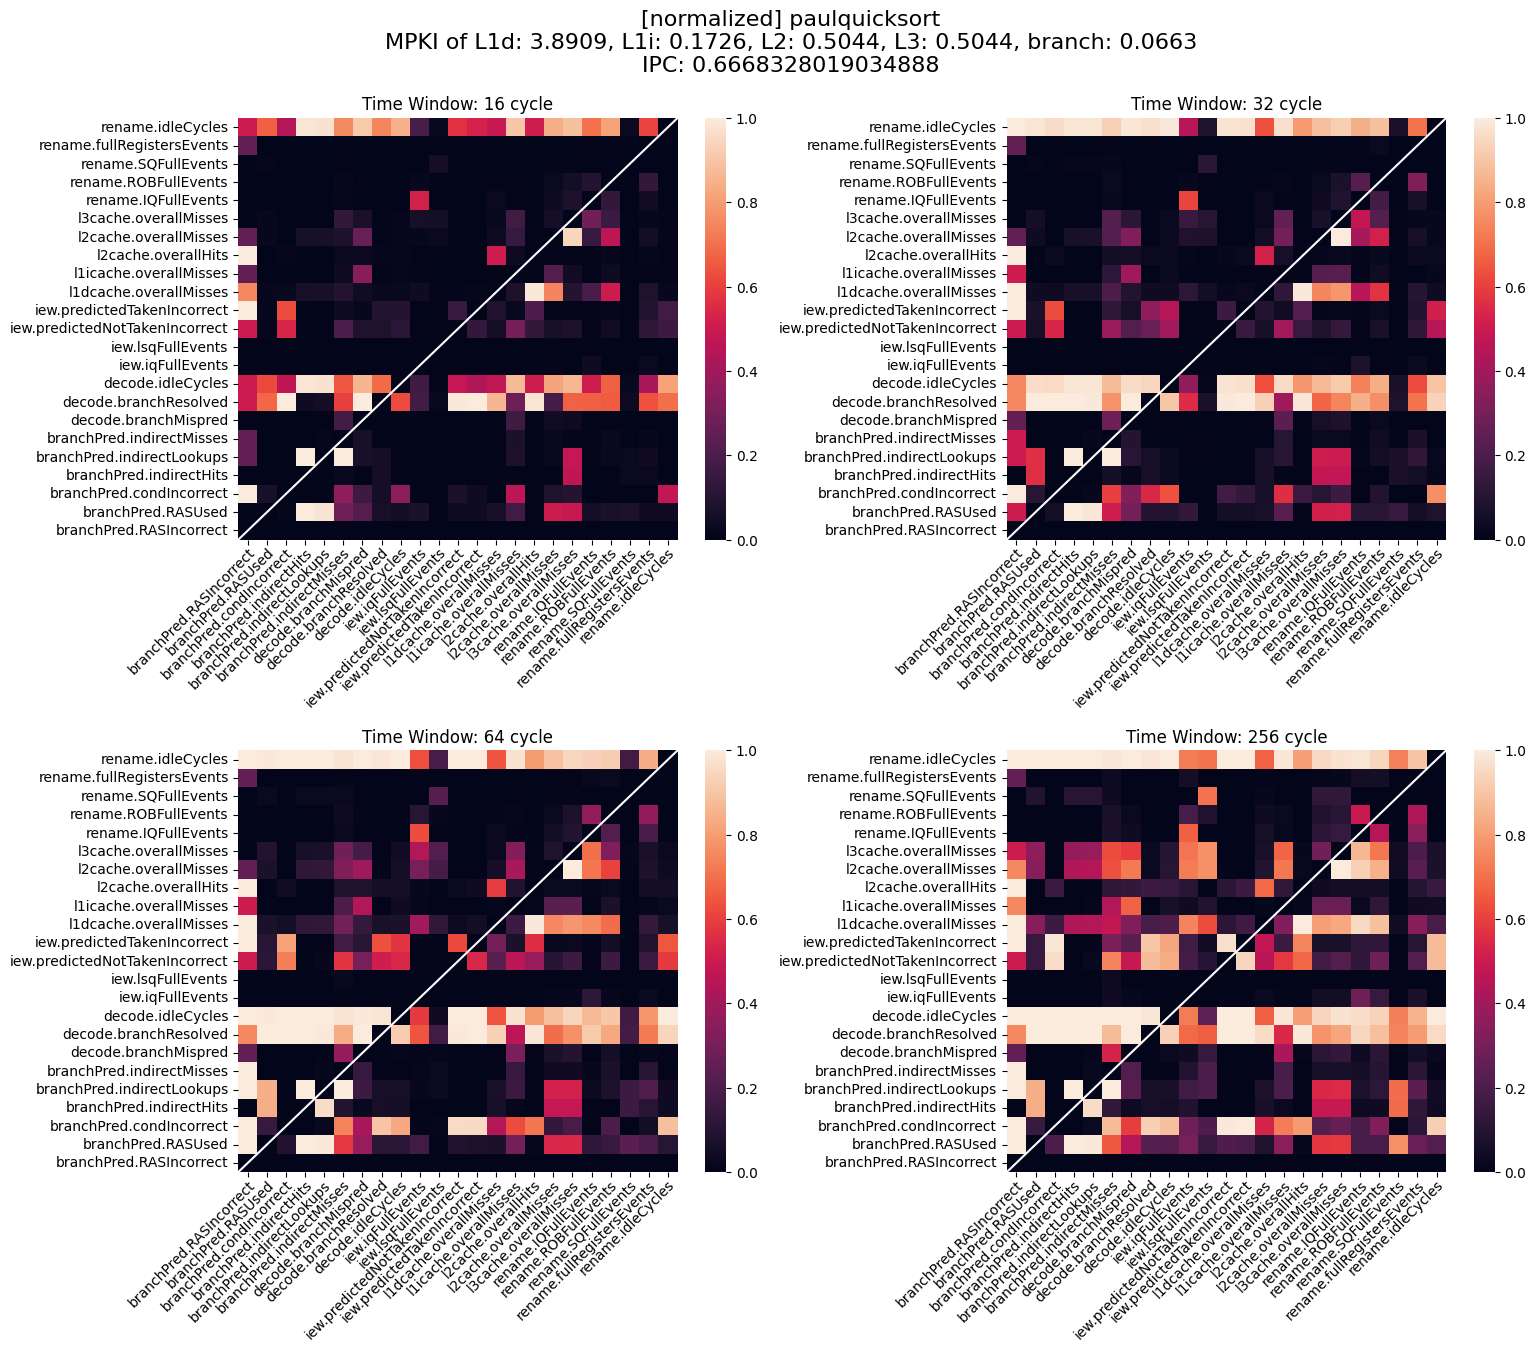

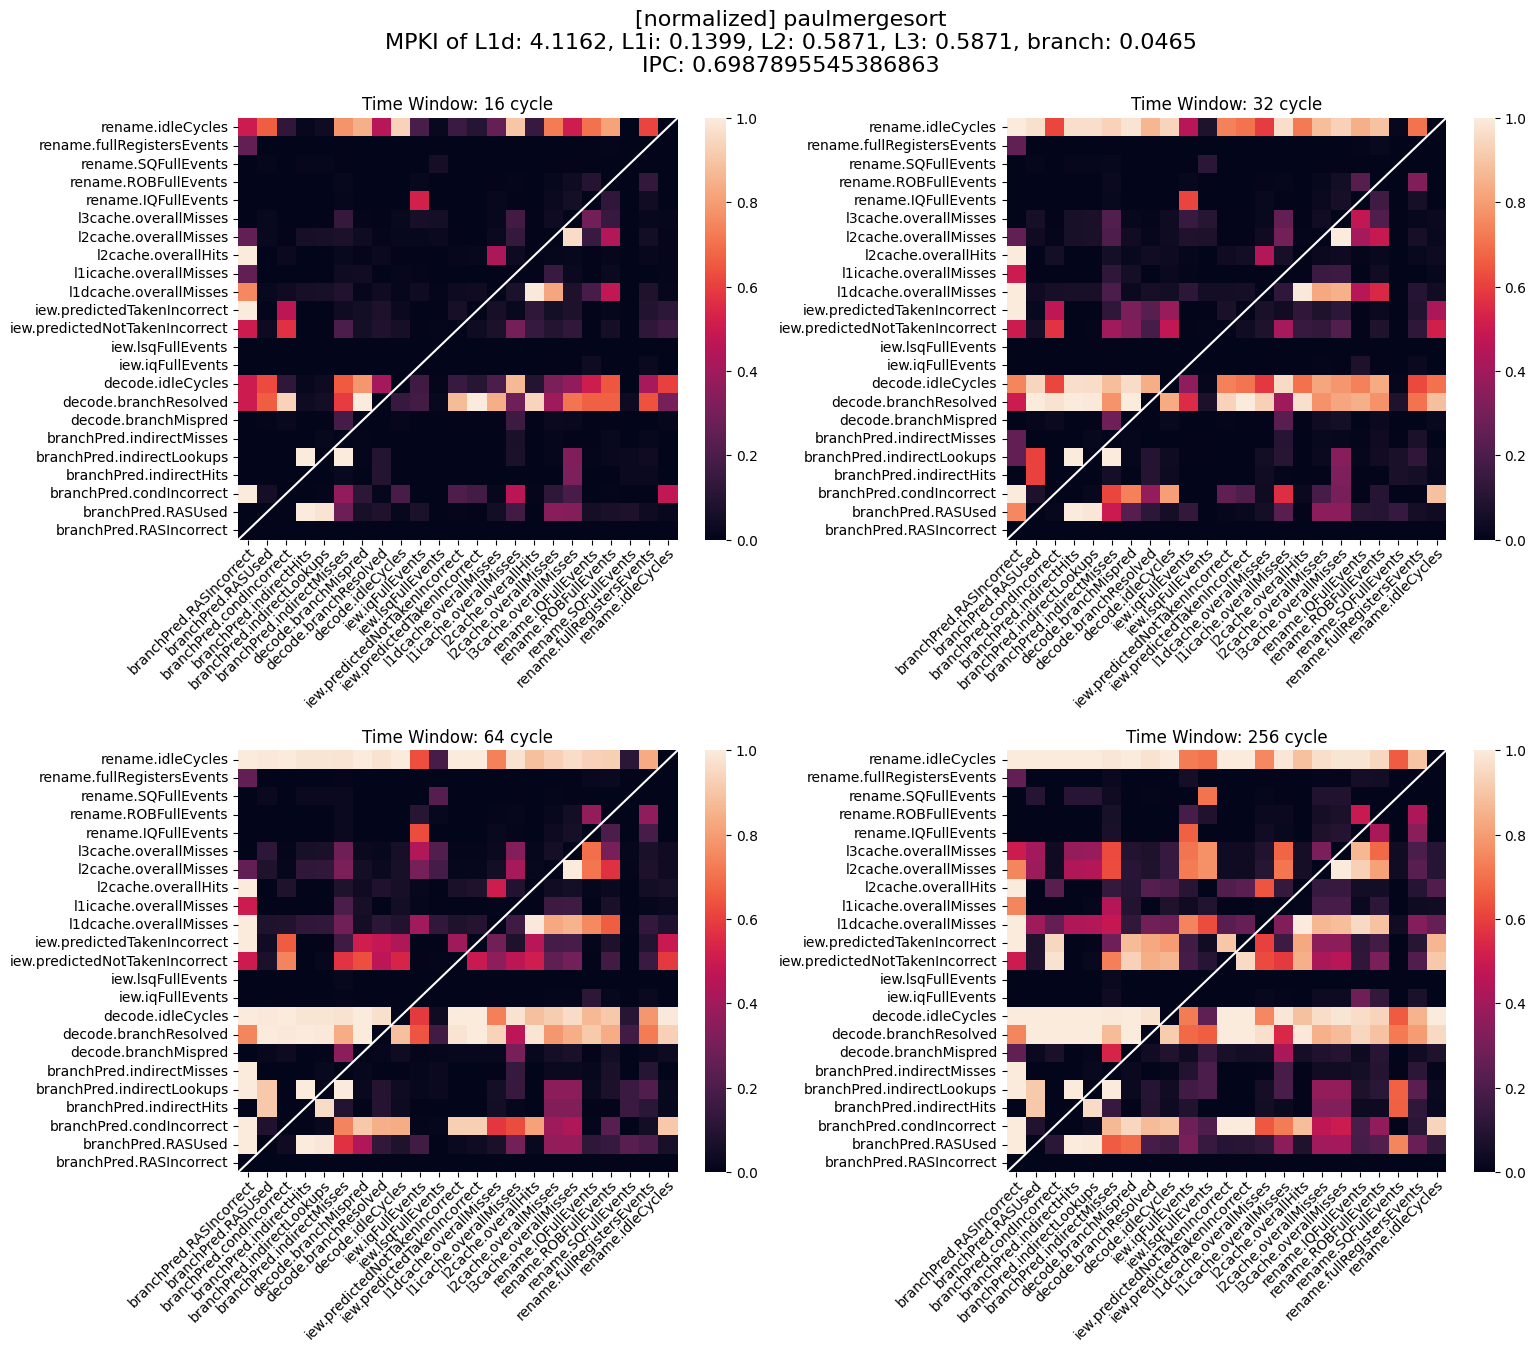

In [32]:
for bench in benchlist:
    # m, p, t, e = analyze(bench, normalize=False)
    # draw_heatmap_group(comment[bench], m['m16v2'],
    #                    m['m32v2'], m['m64v2'], m['m256v2'], e)
    # for normalized version
    m2, p2, t2, e2 = analyze(bench, normalize=True)
    t = "[normalized] "+bench+"\n" + \
        get_miss(bench)+", "+get_branch_miss(bench)+"\n"+get_ipc(bench)
    draw_heatmap_group(t, m2['m16v2'],
                       m2['m32v2'], m2['m64v2'], m2['m256v2'], e2)

In [33]:
# benchlist = '''libcqsort'''.split()
tops = {}
matrixs = {}
top_pairs = {}
events = {}


for bench in benchlist:
    matrixs[bench], top_pairs[bench], tops[bench], events[bench] = analyze(
        bench)

In [34]:
tops_n = {}
matrixs_n = {}
top_pairs_n = {}
events = {}

for bench in benchlist:
    matrixs_n[bench], top_pairs_n[bench], tops_n[bench], events[bench] = analyze(
        bench, normalize=True)\

print(events['stlintrosort'])

['branchPred.RASIncorrect', 'branchPred.RASUsed', 'branchPred.condIncorrect', 'branchPred.indirectHits', 'branchPred.indirectLookups', 'branchPred.indirectMisses', 'decode.branchMispred', 'decode.branchResolved', 'decode.idleCycles', 'iew.iqFullEvents', 'iew.lsqFullEvents', 'iew.predictedNotTakenIncorrect', 'iew.predictedTakenIncorrect', 'l1dcache.overallMisses', 'l1icache.overallMisses', 'l2cache.overallHits', 'l2cache.overallMisses', 'l3cache.overallMisses', 'rename.IQFullEvents', 'rename.ROBFullEvents', 'rename.SQFullEvents', 'rename.fullRegistersEvents', 'rename.idleCycles']


In [35]:
for bench in benchlist:
    print(bench+"-normalized")
    pprint(tops[bench])
    print("top 5 pairs")
    pprint(top_pairs[bench])
    # newline
print()

stlintrosort-normalized
{'top128': ('rename.idleCycles', 'decode.branchResolved'),
 'top16': ('rename.idleCycles', 'decode.branchResolved'),
 'top256': ('rename.idleCycles', 'decode.branchResolved'),
 'top32': ('rename.idleCycles', 'decode.branchResolved'),
 'top64': ('rename.idleCycles', 'decode.branchResolved')}
top 5 pairs
[('decode.branchResolved', 'rename.idleCycles'),
 ('decode.branchResolved', 'decode.idleCycles'),
 ('decode.branchResolved', 'iew.predictedNotTakenIncorrect'),
 ('decode.branchResolved', 'iew.predictedTakenIncorrect'),
 ('branchPred.condIncorrect', 'decode.branchResolved')]
stlstablesort-normalized
{'top128': ('rename.idleCycles', 'decode.branchResolved'),
 'top16': ('rename.idleCycles', 'decode.branchResolved'),
 'top256': ('rename.idleCycles', 'decode.branchResolved'),
 'top32': ('rename.idleCycles', 'decode.branchResolved'),
 'top64': ('rename.idleCycles', 'decode.branchResolved')}
top 5 pairs
[('decode.branchResolved', 'iew.predictedTakenIncorrect'),
 ('decode

In [36]:
count = dict()
for bench in benchlist:
    for pair in top_pairs[bench]:
        count[pair] = count.get(pair, 0) + 1

pprint(count)

{('branchPred.RASUsed', 'decode.branchResolved'): 1,
 ('branchPred.condIncorrect', 'decode.branchResolved'): 9,
 ('branchPred.condIncorrect', 'rename.idleCycles'): 4,
 ('decode.branchResolved', 'decode.idleCycles'): 2,
 ('decode.branchResolved', 'iew.predictedNotTakenIncorrect'): 7,
 ('decode.branchResolved', 'iew.predictedTakenIncorrect'): 8,
 ('decode.branchResolved', 'l1dcache.overallMisses'): 3,
 ('decode.branchResolved', 'l2cache.overallHits'): 3,
 ('decode.branchResolved', 'rename.idleCycles'): 1,
 ('iew.predictedNotTakenIncorrect', 'rename.idleCycles'): 5,
 ('iew.predictedTakenIncorrect', 'rename.idleCycles'): 2}


In [37]:
results = []

for bench in benchlist:
    with open(os.path.join(basedir, bench, bench+".out"), 'r') as file:
        for line in file:
            match = re.search(
                r'Simulated time \(ms\): (\d+\.\d+)', line)
            if match:
                results.append((bench, float(match.group(1))))

results = sorted(results, key=lambda x: x[1])

for bench, time in results:
    print(f"{bench}: {time}")

paulquicksort: 5.63788
stlintrosort: 5.70874
paulmergesort: 6.83744
itermergesort: 7.42996
paulheapsort: 7.56524
libcqsort: 7.83489
combsort: 7.97185
stlstablesort: 8.3175
stlheapsort: 11.68749
